In [129]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

In [130]:
mat = np.empty((0, 4))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['model', 'mae', 'mape', 'rsq'])

# XGBoost

## Model 1

### Train/Test Split

In [131]:
df = pd.read_csv('multivar.csv') 
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [132]:
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)

In [133]:
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
print(train.shape, test.shape)

(1416, 67) (607, 67)


In [134]:
X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1416, 66) (1416,) (607, 66) (607,)


### Model 

In [135]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[16:21:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:496.49078	validation_1-rmse:4496.82422
[1]	validation_0-rmse:379.89758	validation_1-rmse:4427.04053
[2]	validation_0-rmse:295.89816	validation_1-rmse:4093.03320
[3]	validation_0-rmse:233.39131	validation_1-rmse:3934.13037
[4]	validation_0-rmse:186.75737	validation_1-rmse:3802.28467
[5]	validation_0-rmse:150.89937	validation_1-rmse:3782.19897
[6]	validation_0-rmse:123.33690	validation_1-rmse:3568.56079
[7]	validation_0-rmse:101.62997	validation_1-rmse:3395.05444
[8]	validation_0-rmse:84.46410	v

[65]	validation_0-rmse:1.35137	validation_1-rmse:2490.45117
[66]	validation_0-rmse:1.31738	validation_1-rmse:2490.37671
[67]	validation_0-rmse:1.26258	validation_1-rmse:2490.37866
[68]	validation_0-rmse:1.20025	validation_1-rmse:2490.39770
[69]	validation_0-rmse:1.17186	validation_1-rmse:2490.41040
[70]	validation_0-rmse:1.16252	validation_1-rmse:2490.39233
[71]	validation_0-rmse:1.13998	validation_1-rmse:2490.39111
[72]	validation_0-rmse:1.09337	validation_1-rmse:2490.38525
[73]	validation_0-rmse:1.05384	validation_1-rmse:2490.33545
[74]	validation_0-rmse:1.03288	validation_1-rmse:2490.31348
[75]	validation_0-rmse:1.01087	validation_1-rmse:2490.29004
[76]	validation_0-rmse:0.99592	validation_1-rmse:2490.29175
[77]	validation_0-rmse:0.98656	validation_1-rmse:2490.28320
[78]	validation_0-rmse:0.93369	validation_1-rmse:2490.28296
[79]	validation_0-rmse:0.91147	validation_1-rmse:2490.27661
[80]	validation_0-rmse:0.88382	validation_1-rmse:2490.27759
[81]	validation_0-rmse:0.86194	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

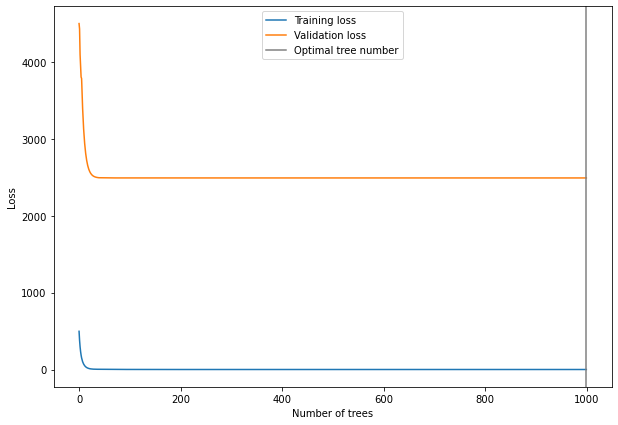

In [136]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [137]:
reg.best_iteration

999

### Feature Importance

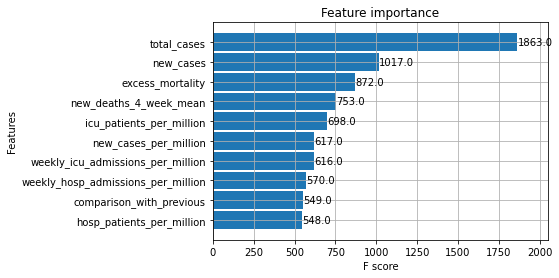

In [138]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

### Forcast on Test Set

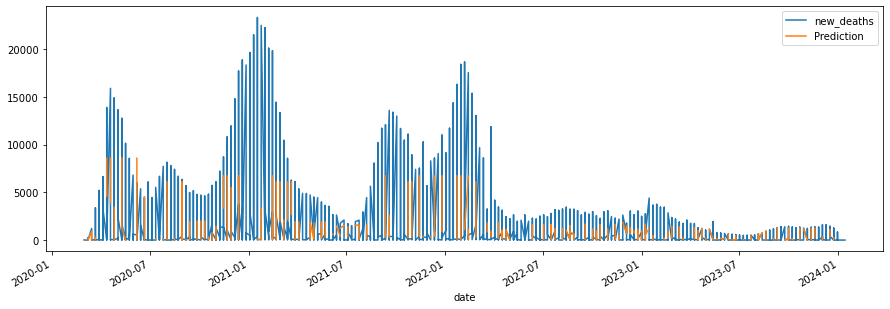

In [139]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

### Metrics

In [140]:
mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
mape = np.mean(np.abs((test['new_deaths'] - test['Prediction']) / (test['new_deaths'] + 1))) * 100
r2 = r2_score(test['new_deaths'], test['Prediction'])
new_row = {'model': '1', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## Model 2

### Train/Test Split

In [141]:
df = pd.read_csv('multivar.csv') 
df = df[['total_cases', 'new_cases', 'excess_mortality', 'new_deaths_4_week_mean', 'icu_patients_per_million',
         'new_cases_per_million', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million', 
         'comparison_with_previous', 'hosp_patients_per_million', 'date', 'new_deaths', 'location']]
categorical_cols = ['location']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [142]:
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
print(train.shape, test.shape)

(1416, 21) (607, 21)


In [143]:
X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1416, 20) (1416,) (607, 20) (607,)


### Model

In [144]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[16:22:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:502.91049	validation_1-rmse:4126.01611
[1]	validation_0-rmse:389.12854	validation_1-rmse:3909.69434
[2]	validation_0-rmse:305.50107	validation_1-rmse:3794.80151
[3]	validation_0-rmse:243.72871	validation_1-rmse:3677.25635
[4]	validation_0-rmse:197.00523	validation_1-rmse:3626.59058
[5]	validation_0-rmse:160.62221	validation_1-rmse:3486.59814
[6]	validation_0-rmse:132.26640	validation_1-rmse:3440.47632
[7]	validation_0-rmse:109.78507	validation_1-rmse:3414.27832
[8]	validation_0-rmse:91.80608	v

[34]	validation_0-rmse:10.75639	validation_1-rmse:3265.52588
[35]	validation_0-rmse:10.56696	validation_1-rmse:3264.99023
[36]	validation_0-rmse:10.11711	validation_1-rmse:3264.53711
[37]	validation_0-rmse:10.00613	validation_1-rmse:3264.17578
[38]	validation_0-rmse:9.66998	validation_1-rmse:3264.47266
[39]	validation_0-rmse:9.62838	validation_1-rmse:3264.17456
[40]	validation_0-rmse:9.41557	validation_1-rmse:3264.33081
[41]	validation_0-rmse:8.92891	validation_1-rmse:3264.60327
[42]	validation_0-rmse:8.36723	validation_1-rmse:3263.36475
[43]	validation_0-rmse:8.10231	validation_1-rmse:3263.37378
[44]	validation_0-rmse:7.71660	validation_1-rmse:3263.03516
[45]	validation_0-rmse:7.64109	validation_1-rmse:3263.08179
[46]	validation_0-rmse:7.59972	validation_1-rmse:3263.12354
[47]	validation_0-rmse:7.21782	validation_1-rmse:3263.19605
[48]	validation_0-rmse:7.06984	validation_1-rmse:3263.58447
[49]	validation_0-rmse:6.84710	validation_1-rmse:3263.79492
[50]	validation_0-rmse:6.68966	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

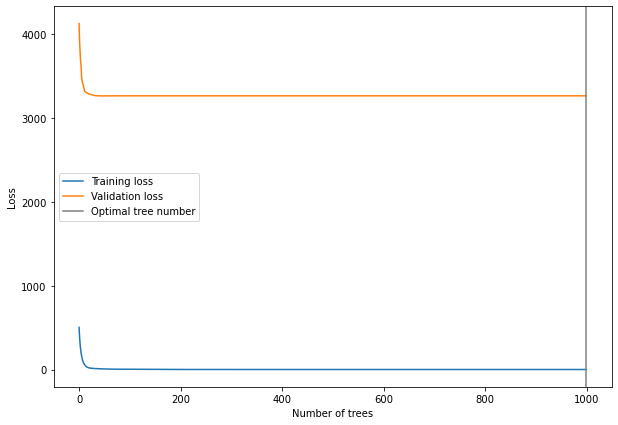

In [145]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [146]:
reg.best_iteration

999

### Forcast on Test Set

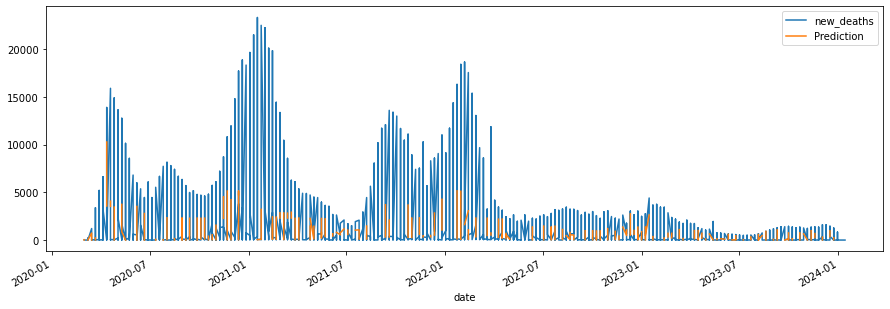

In [147]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

### Metrics

In [148]:
mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
mape = np.mean(np.abs((test['new_deaths'] - test['Prediction']) / (test['new_deaths'] + 1))) * 100
r2 = r2_score(test['new_deaths'], test['Prediction'])
new_row = {'model': '2', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Results

In [149]:
metrics

,model,mae,mape,rsq
0,1,926.029677,111.744112,0.620601
1,2,1299.653842,233.597377,0.347993
